 #### HF: https://huggingface.co/amazon/chronos-t5-base  
 #### Github: https://github.com/amazon-science/chronos-forecasting

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Test: context 96 prediction 64

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from utils.evaluation import Normalizer
from data.snp500 import snp500_daily_cp
from utils.metrics import metric

# Initialize constants
CONTEXT_WINDOW = 96  
PREDICTION_WINDOW = 192  # Model is suggested to not predict more than 64 steps ahead

# Initialize models and normalizer
normalizer = Normalizer(norm_type="standardization")
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="mps",  # Change to "cuda" for NVIDIA GPUs
    torch_dtype=torch.bfloat16,
)

# Prepare the data
sp500_d = snp500_daily_cp.reset_index()[['Date', 'Close']]
sp500_d['Normalized_Close'] = normalizer.normalize(sp500_d[['Close']])

# Function to generate and process forecast
def generate_forecast(context):
    context_tensor = torch.tensor(context, dtype=torch.float32).flatten()
    forecast = pipeline.predict(context_tensor, PREDICTION_WINDOW)
    forecast_np = forecast[0].numpy()
    
    # Extract and denormalize quantiles
    low, median, high = np.quantile(forecast_np, [0.1, 0.5, 0.9], axis=0)
    low_denorm = normalizer.denormalize(pd.DataFrame(low, columns=["Close"])).values.flatten()
    median_denorm = normalizer.denormalize(pd.DataFrame(median, columns=["Close"])).values.flatten()
    high_denorm = normalizer.denormalize(pd.DataFrame(high, columns=["Close"])).values.flatten()
    
    return low_denorm, median_denorm, high_denorm

def calculate_metrics(actual, predicted, insample=None):
    """
    Calculate all metrics using the metrics.py implementations
    """
    # Convert inputs to numpy arrays if they're not already
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    
    # Calculate metrics using the metric function from metrics.py
    if insample is not None:
        mae, mse, rmse, mape, mspe, mase = metric(predicted, actual, insample=insample)
    else:
        mae, mse, rmse, mape, mspe = metric(predicted, actual)
        mase = None
    
    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape * 100,  # Convert to percentage
        'SMAPE': smape,
        'MASE': mase
    }
    
    return metrics

# Function to create visualization with zoomed context
def plot_forecast(data, context_window, prediction_window, 
                 median_forecast, low_forecast, high_forecast, title):
    plt.figure(figsize=(12, 6))
    
    # Get the last point of historical context
    last_context_point = data['Close'].iloc[-prediction_window - 1]
    
    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)
    
    # Create forecast dates including the last context point
    forecast_dates = pd.concat([
        data['Date'].iloc[-(prediction_window + 1):-prediction_window],  # Last context point
        data['Date'].iloc[-prediction_window:]  # Forecast range
    ])
    
    # Get actual prices including the last context point
    actual_prices = data['Close'].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)
    
    # Plot historical context (zoomed to relevant window)
    plt.plot(
        data['Date'].iloc[-(context_window + prediction_window):-prediction_window],
        data['Close'].iloc[-(context_window + prediction_window):-prediction_window],
        color="royalblue", 
        label="Historical Data (Context)"
    )
    
    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")
    
    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval"
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Generate full period forecast
context = sp500_d['Normalized_Close'].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d['Close'].values[-PREDICTION_WINDOW:]
insample_data = sp500_d['Close'].values[-CONTEXT_WINDOW-PREDICTION_WINDOW:-PREDICTION_WINDOW]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    'S&P 500 Price Prediction with Chronos-T5'
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d['Date'] >= covid_start_date) & 
    (sp500_d['Date'] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = covid_data['Normalized_Close'].iloc[
    -(CONTEXT_WINDOW + PREDICTION_WINDOW):-PREDICTION_WINDOW
].values

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data['Close'].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = covid_data['Close'].iloc[-CONTEXT_WINDOW-PREDICTION_WINDOW:-PREDICTION_WINDOW].values
metrics_covid = calculate_metrics(actual_prices_covid, median_covid, insample=insample_data_covid)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    print(f"{metric_name}: {value:.4f}")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    'S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)'
)

ModuleNotFoundError: No module named 'utils.evaluation'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 



Full Period Metrics:
MAE: 570.2483
MSE: 380562.2318
RMSE: 616.8973
MAPE: 10.5373
SMAPE: 9.9131
MASE: 21.9906


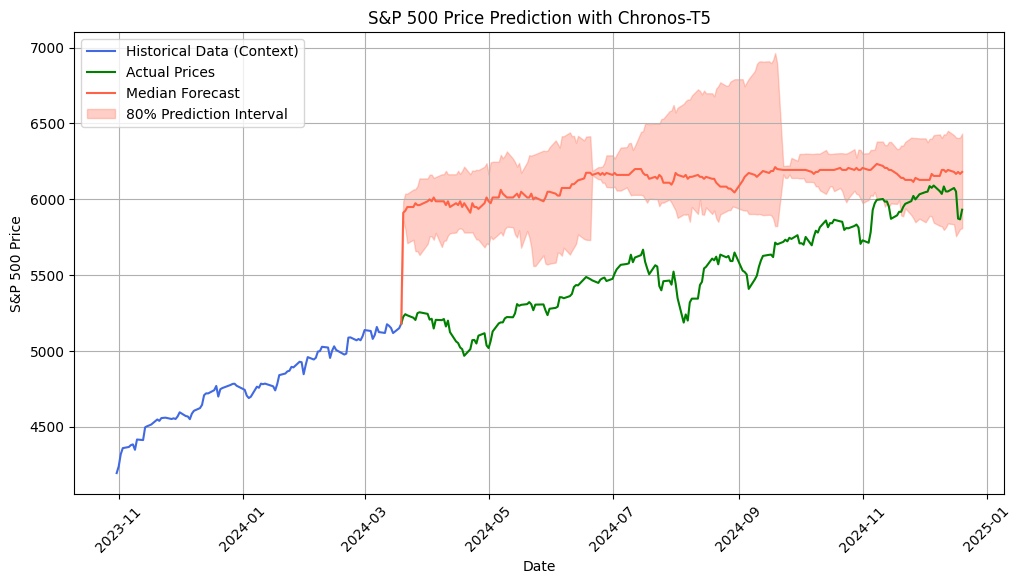

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 



COVID Period Metrics:
MAE: 551.2461
MSE: 366367.8806
RMSE: 605.2833
MAPE: 12.3007
SMAPE: 13.2670
MASE: 21.2155


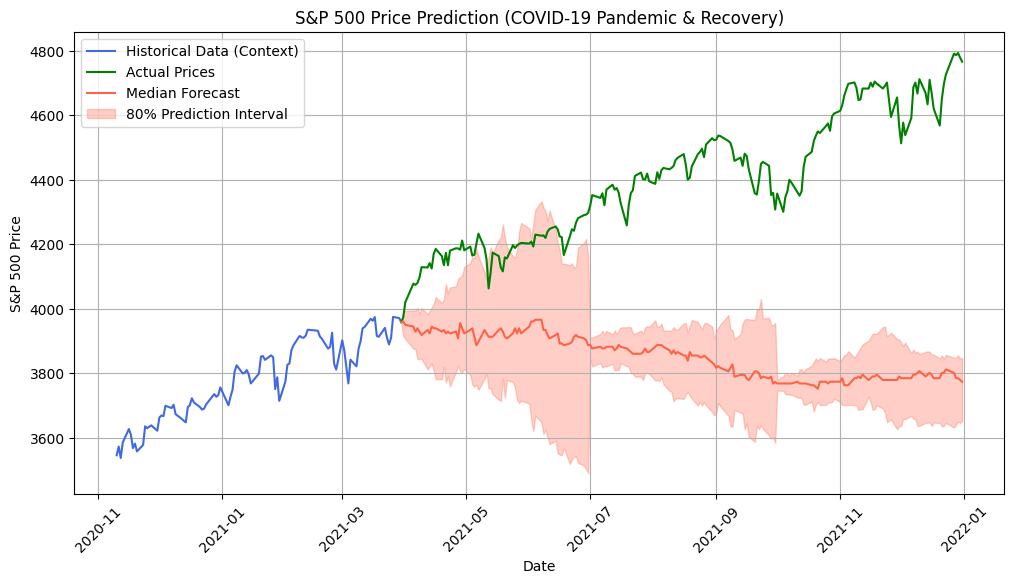

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from utils.normalizer import Normalizer
from data.snp500 import snp500_daily
from utils.metrics import metric

# Initialize constants
CONTEXT_WINDOW = 96
PREDICTION_WINDOW = 192  # Model is suggested to not predict more than 64 steps ahead

# Initialize models and normalizer
normalizer = Normalizer(norm_type="standardization")
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="mps",  # Change to "cuda" for NVIDIA GPUs
    torch_dtype=torch.bfloat16,
)

# Prepare the data
sp500_d = snp500_daily.reset_index()[['Date', 'Close']]
sp500_d['Normalized_Close'] = normalizer.normalize(sp500_d[['Close']])

# Function to generate and process forecast
def generate_forecast(context):
    context_tensor = torch.tensor(context, dtype=torch.float32).flatten()
    forecast = pipeline.predict(context_tensor, PREDICTION_WINDOW)
    forecast_np = forecast[0].numpy()
    
    # Extract and denormalize quantiles
    low, median, high = np.quantile(forecast_np, [0.1, 0.5, 0.9], axis=0)
    low_denorm = normalizer.denormalize(pd.DataFrame(low, columns=["Close"])).values.flatten()
    median_denorm = normalizer.denormalize(pd.DataFrame(median, columns=["Close"])).values.flatten()
    high_denorm = normalizer.denormalize(pd.DataFrame(high, columns=["Close"])).values.flatten()
    
    return low_denorm, median_denorm, high_denorm

def calculate_metrics(actual, predicted, insample=None):
    """
    Calculate all metrics using the metrics.py implementations
    """
    # Convert inputs to numpy arrays if they're not already
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()
    
    # Calculate metrics using the metric function from metrics.py
    if insample is not None:
        mae, mse, rmse, mape, mspe, mase = metric(predicted, actual, insample=insample)
    else:
        mae, mse, rmse, mape, mspe = metric(predicted, actual)
        mase = None
    
    # Calculate SMAPE
    smape = 200 * np.mean(
        np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual))
    )
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape * 100,  # Convert to percentage
        'SMAPE': smape,
        'MASE': mase
    }
    
    return metrics

# Function to create visualization with zoomed context
def plot_forecast(data, context_window, prediction_window, 
                 median_forecast, low_forecast, high_forecast, title):
    plt.figure(figsize=(12, 6))
    
    # Get the last point of historical context
    last_context_point = data['Close'].iloc[-prediction_window - 1]
    
    # Add last context point to forecasts for continuity
    median_forecast = np.insert(median_forecast, 0, last_context_point)
    low_forecast = np.insert(low_forecast, 0, last_context_point)
    high_forecast = np.insert(high_forecast, 0, last_context_point)
    
    # Create forecast dates including the last context point
    forecast_dates = pd.concat([
        data['Date'].iloc[-(prediction_window + 1):-prediction_window],  # Last context point
        data['Date'].iloc[-prediction_window:]  # Forecast range
    ])
    
    # Get actual prices including the last context point
    actual_prices = data['Close'].iloc[-prediction_window:].values
    actual_prices = np.insert(actual_prices, 0, last_context_point)
    
    # Plot historical context (zoomed to relevant window)
    plt.plot(
        data['Date'].iloc[-(context_window + prediction_window):-prediction_window],
        data['Close'].iloc[-(context_window + prediction_window):-prediction_window],
        color="royalblue", 
        label="Historical Data (Context)"
    )
    
    # Plot actual prices
    plt.plot(forecast_dates, actual_prices, color="green", label="Actual Prices")
    
    # Plot forecast
    plt.plot(forecast_dates, median_forecast, color="tomato", label="Median Forecast")
    plt.fill_between(
        forecast_dates,
        low_forecast,
        high_forecast,
        color="tomato",
        alpha=0.3,
        label="80% Prediction Interval"
    )
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()

# Generate full period forecast
context = sp500_d['Normalized_Close'].values[-CONTEXT_WINDOW:]
low, median, high = generate_forecast(context)

# Calculate and print metrics for full period
actual_prices = sp500_d['Close'].values[-PREDICTION_WINDOW:]
insample_data = sp500_d['Close'].values[-CONTEXT_WINDOW-PREDICTION_WINDOW:-PREDICTION_WINDOW]
metrics = calculate_metrics(actual_prices, median, insample=insample_data)

print("\nFull Period Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Plot full period forecast
plot_forecast(
    sp500_d,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median,
    low,
    high,
    'S&P 500 Price Prediction with Chronos-T5'
)

# COVID-19 Period Analysis
covid_start_date = "2020-03-01"
covid_end_date = "2021-12-31"

covid_data = sp500_d[
    (sp500_d['Date'] >= covid_start_date) & 
    (sp500_d['Date'] <= covid_end_date)
].reset_index(drop=True)

# Generate COVID period forecast
covid_context = covid_data['Normalized_Close'].iloc[
    -(CONTEXT_WINDOW + PREDICTION_WINDOW):-PREDICTION_WINDOW
].values

low_covid, median_covid, high_covid = generate_forecast(covid_context)

# Calculate and print COVID period metrics
actual_prices_covid = covid_data['Close'].iloc[-PREDICTION_WINDOW:].values
insample_data_covid = covid_data['Close'].iloc[-CONTEXT_WINDOW-PREDICTION_WINDOW:-PREDICTION_WINDOW].values
metrics_covid = calculate_metrics(actual_prices_covid, median_covid, insample=insample_data_covid)

print("\nCOVID Period Metrics:")
for metric_name, value in metrics_covid.items():
    print(f"{metric_name}: {value:.4f}")

# Plot COVID period forecast
plot_forecast(
    covid_data,
    CONTEXT_WINDOW,
    PREDICTION_WINDOW,
    median_covid,
    low_covid,
    high_covid,
    'S&P 500 Price Prediction (COVID-19 Pandemic & Recovery)'
)

# Experimenting with different context and prediction windows for different frequencies: daily, weekly, monthly


Running daily frequency experiments...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

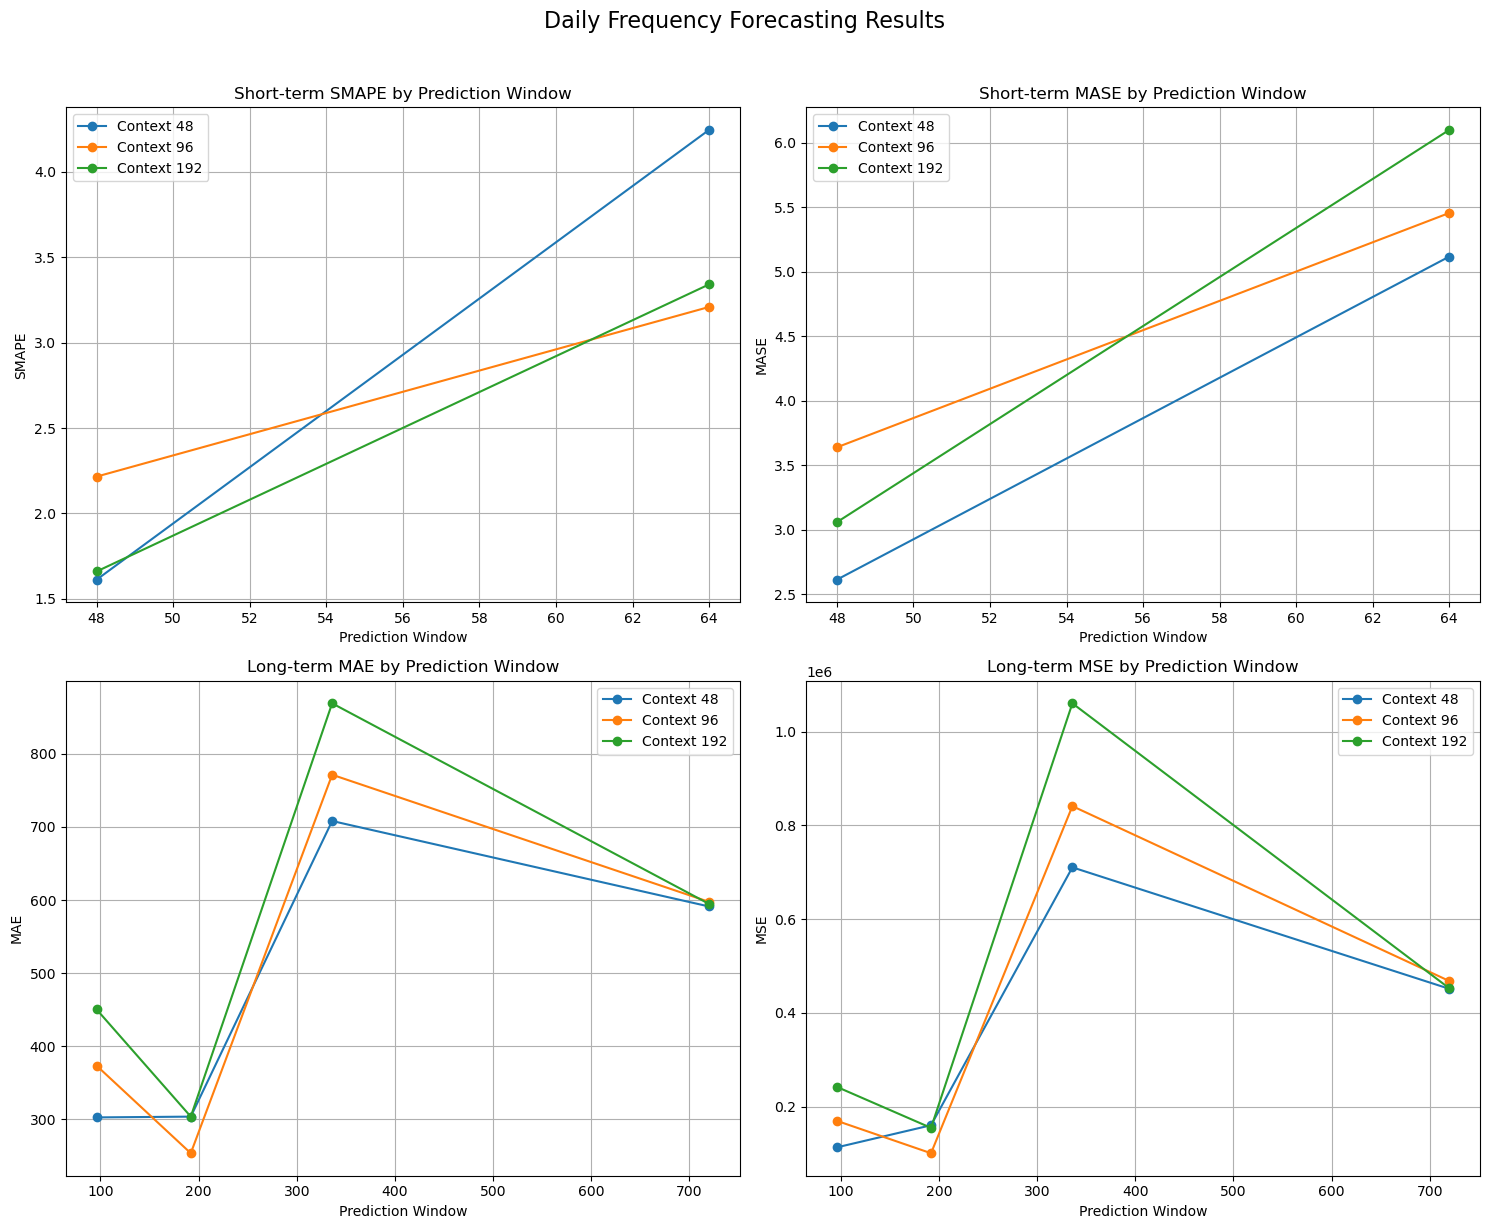


Daily Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE         MSE  \
Context Window Prediction Window                                         
48             48                  95.5471  1.6012  2.6144  13185.4699   
               64                 245.9484  4.1338  5.1194  77875.7063   
96             48                 130.8707  2.1903  3.6403  24247.5870   
               64                 187.1328  3.1344  5.4573  52380.1980   
192            48                  98.3547  1.6509  3.0599  13931.1683   
               64                 194.6451  3.2630  6.1014  54793.5973   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
48             48                 114.8280  1.6123  
               64                 279.0622  4.2457  
96             48                 155.7164  2.2158  
               64                 228.8672  3.2090  
192            48             

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


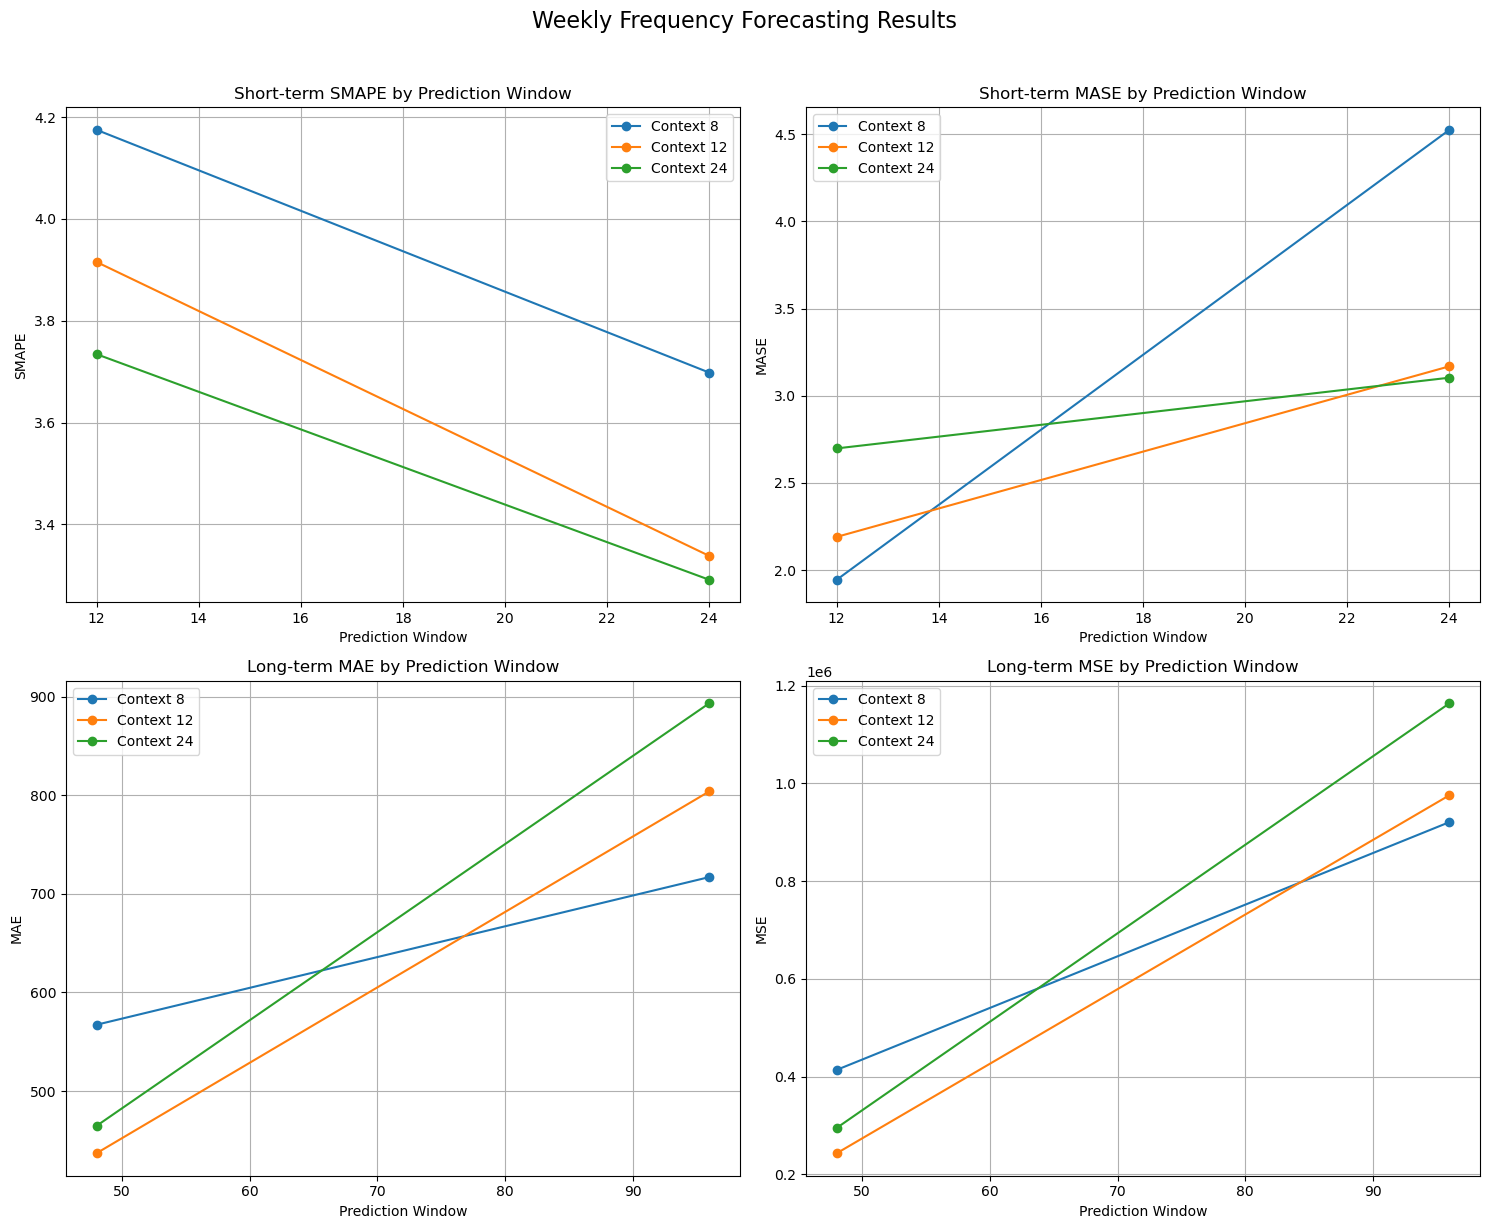


Weekly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE         MSE  \
Context Window Prediction Window                                         
8              12                 242.7497  4.0681  1.9443  74877.0288   
               24                 211.1729  3.6310  4.5258  63236.5275   
12             12                 228.0090  3.8173  2.1902  68841.8920   
               24                 190.8936  3.2909  3.1688  54734.1147   
24             12                 217.7025  3.6479  2.6978  60683.5770   
               24                 188.2667  3.2468  3.1035  50600.4647   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
8              12                 273.6367  4.1751  
               24                 251.4687  3.6983  
12             12                 262.3774  3.9155  
               24                 233.9532  3.3384  
24             12            

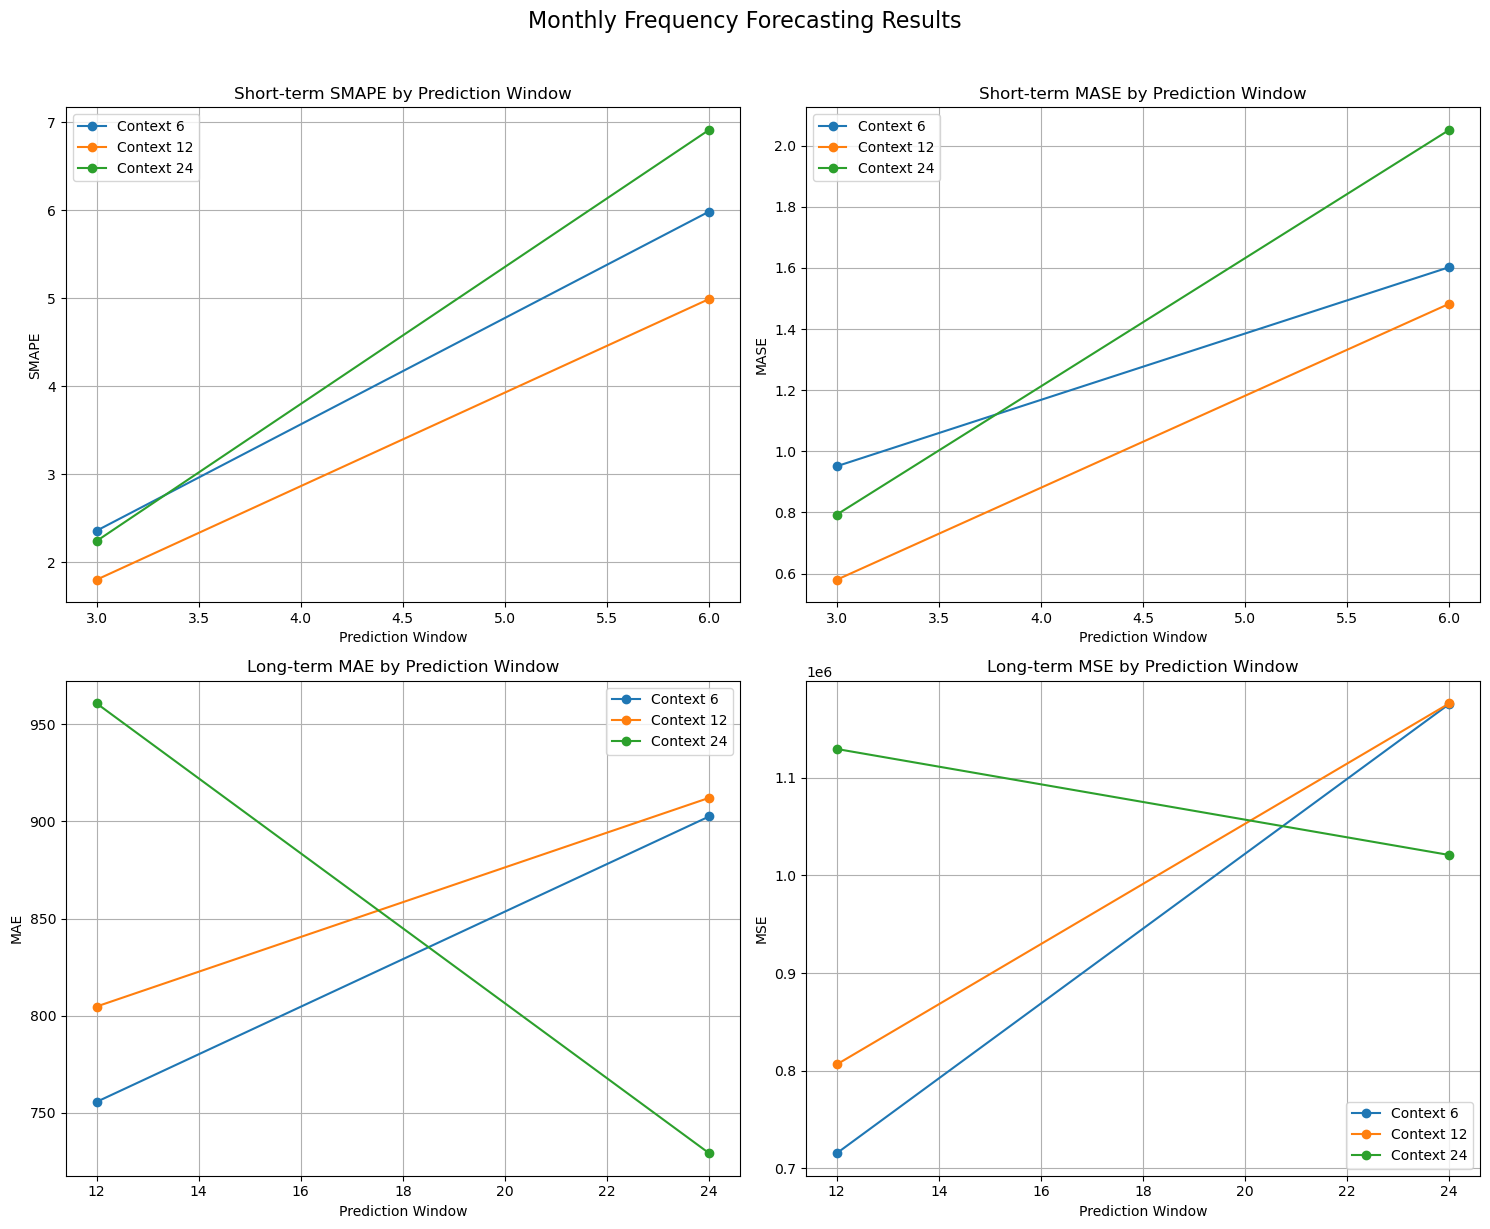


Monthly Frequency Results:

Short-term Forecasting Results:
Metric                                 MAE    MAPE    MASE          MSE  \
Context Window Prediction Window                                          
6              3                  138.2744  2.3330  0.9513   23300.7494   
               6                  337.2168  5.7775  1.6025  138866.9510   
12             3                  105.7582  1.7887  0.5799   15064.2463   
               6                  282.9861  4.8285  1.4829  109853.9953   
24             3                  131.4501  2.2128  0.7931   23517.9511   
               6                  387.2587  6.6293  2.0517  188790.4554   

Metric                                RMSE   SMAPE  
Context Window Prediction Window                    
6              3                  152.6458  2.3568  
               6                  372.6486  5.9854  
12             3                  122.7365  1.8000  
               6                  331.4423  4.9914  
24             3    

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chronos import ChronosPipeline
from data.snp500 import snp500_daily_cp, snp500_weekly_cp, snp500_monthly_cp
from utils.evaluate import ContextPredictionWindowEvaluator

def plot_results_by_frequency(results_df, frequency):
    """
    Create plots for short-term and long-term metrics
    
    Args:
        results_df: DataFrame with results from experiment runner
        frequency: String indicating the data frequency
    """
    # Set up the figure with two rows (short-term and long-term)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{frequency.capitalize()} Frequency Forecasting Results', fontsize=16, y=1.02)
    
    # Short-term metrics (SMAPE and MASE)
    short_term = results_df[results_df['Horizon'] == 'short_term']
    context_windows = sorted(short_term['Context Window'].unique())
    pred_windows = sorted(short_term['Prediction Window'].unique())
    
    # Plot SMAPE
    ax = axes[0, 0]
    for context in context_windows:
        data = short_term[
            (short_term['Context Window'] == context) & 
            (short_term['Metric'] == 'SMAPE')
        ]
        ax.plot(data['Prediction Window'], data['Value'], 
                marker='o', label=f'Context {context}')
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('SMAPE')
    ax.set_title('Short-term SMAPE by Prediction Window')
    ax.grid(True)
    ax.legend()
    
    # Plot MASE
    ax = axes[0, 1]
    for context in context_windows:
        data = short_term[
            (short_term['Context Window'] == context) & 
            (short_term['Metric'] == 'MASE')
        ]
        ax.plot(data['Prediction Window'], data['Value'], 
                marker='o', label=f'Context {context}')
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('MASE')
    ax.set_title('Short-term MASE by Prediction Window')
    ax.grid(True)
    ax.legend()
    
    # Long-term metrics (MAE and MSE)
    long_term = results_df[results_df['Horizon'] == 'long_term']
    
    # Plot MAE
    ax = axes[1, 0]
    for context in context_windows:
        data = long_term[
            (long_term['Context Window'] == context) & 
            (long_term['Metric'] == 'MAE')
        ]
        ax.plot(data['Prediction Window'], data['Value'], 
                marker='o', label=f'Context {context}')
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('MAE')
    ax.set_title('Long-term MAE by Prediction Window')
    ax.grid(True)
    ax.legend()
    
    # Plot MSE
    ax = axes[1, 1]
    for context in context_windows:
        data = long_term[
            (long_term['Context Window'] == context) & 
            (long_term['Metric'] == 'MSE')
        ]
        ax.plot(data['Prediction Window'], data['Value'], 
                marker='o', label=f'Context {context}')
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('MSE')
    ax.set_title('Long-term MSE by Prediction Window')
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Define forecast function for Chronos
def chronos_forecast(model, context, prediction_window):
    """Forecast function for Chronos model"""
    context_tensor = torch.tensor(context, dtype=torch.float32).flatten()
    forecast = model.predict(context_tensor, prediction_window)
    forecast_np = forecast[0].numpy()
    
    # Extract quantiles
    low, median, high = np.quantile(forecast_np, [0.1, 0.5, 0.9], axis=0)
    return low, median, high

# Initialize model and experiment runner
chronos_model = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

experiments = ContextPredictionWindowEvaluator(
    model=chronos_model,
    forecast_fn=chronos_forecast
)

# Dictionary to store results for each frequency
frequency_results = {}

# Run experiments for each frequency
frequencies = {
    'daily': snp500_daily_cp,
    'weekly': snp500_weekly_cp,
    'monthly': snp500_monthly_cp
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency experiments...")
    
    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    frequency_results[freq] = results
    
    # Format results
    df_results = experiments.format_results(results)
    
    # Create visualizations
    plot_results_by_frequency(df_results, freq)
    
    # Create separate DataFrames for short-term and long-term results
    short_term_df = df_results[df_results['Horizon'] == 'short_term'].pivot_table(
        index=['Context Window', 'Prediction Window'],
        columns='Metric',
        values='Value'
    ).round(4)
    
    long_term_df = df_results[df_results['Horizon'] == 'long_term'].pivot_table(
        index=['Context Window', 'Prediction Window'],
        columns='Metric',
        values='Value'
    ).round(4)
    
    print(f"\n{freq.capitalize()} Frequency Results:")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)

# Plot forecasting visuals of best results

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


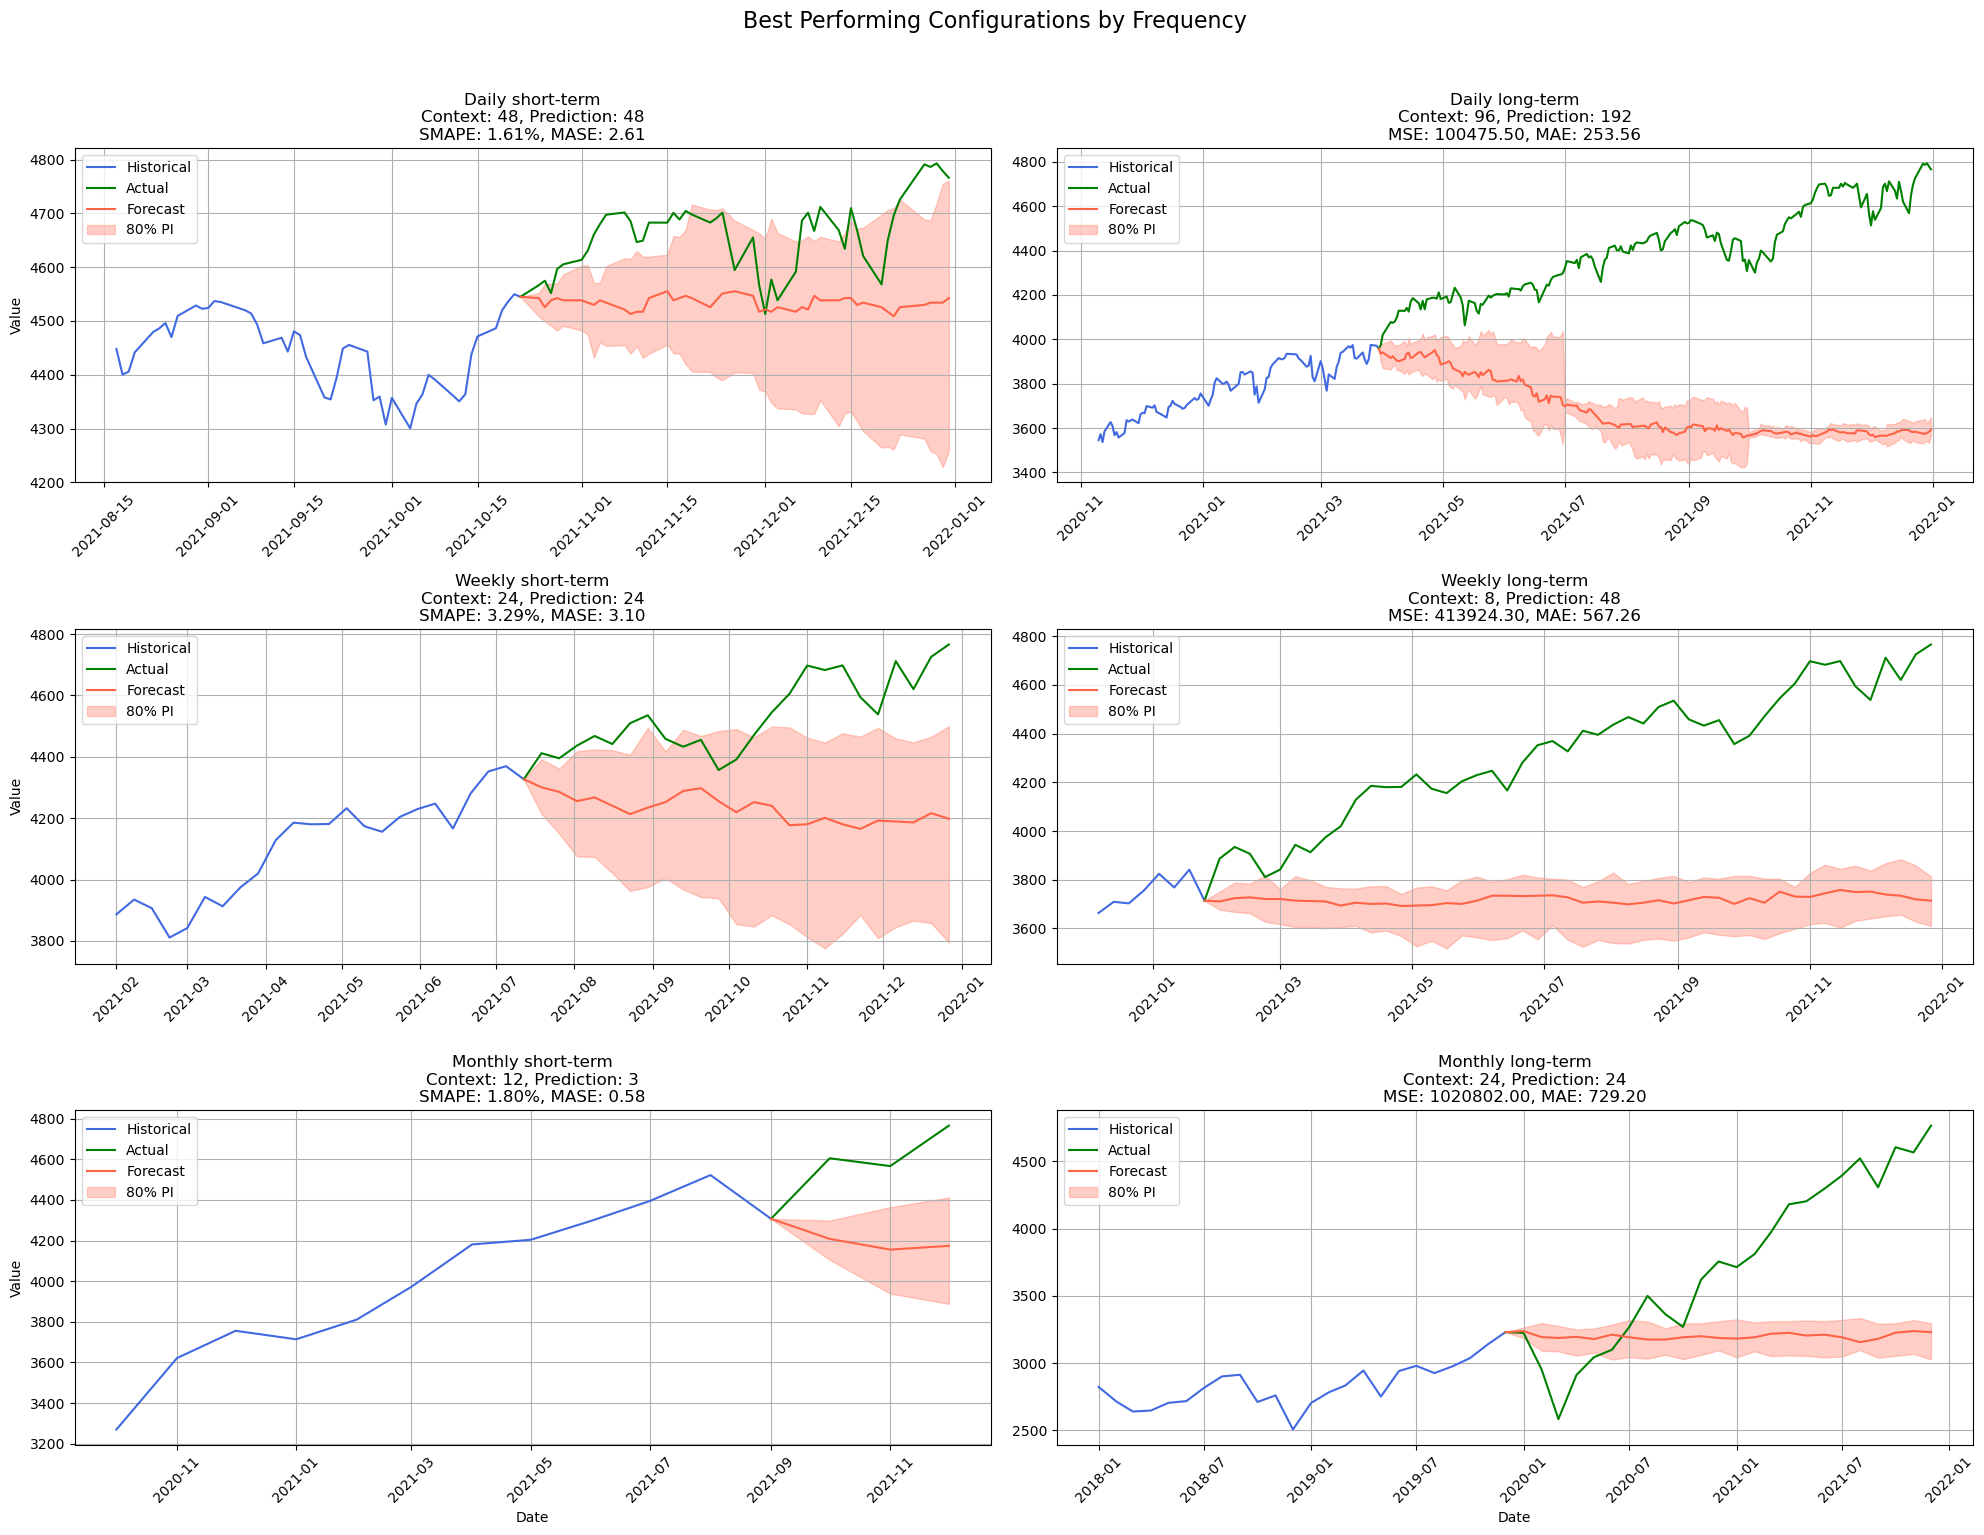

In [13]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from chronos import ChronosPipeline
from utils.evaluation import Normalizer

def plot_best_configs(data_dict, configs_dict, covid_period=("2018-01-01", "2021-12-31")):
    """
    Plot best performing configurations for each frequency
    
    Args:
        data_dict: Dictionary with frequency as key and DataFrame as value
        configs_dict: Dictionary with best configurations for each frequency
        covid_period: Tuple of (start_date, end_date)
    """
    # Initialize model and normalizer
    normalizer = Normalizer(norm_type="standardization")
    pipeline = ChronosPipeline.from_pretrained(
        "amazon/chronos-t5-base",
        device_map="mps",
        torch_dtype=torch.bfloat16,
    )
    
    # Create figure with 6 subplots (2 per frequency)
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Best Performing Configurations by Frequency', fontsize=16, y=1.02)
    
    # Plot counter
    plot_idx = 1
    
    for freq in ['daily', 'weekly', 'monthly']:
        data = data_dict[freq].copy()
        
        # Ensure data has correct format
        if isinstance(data.index, pd.DatetimeIndex):
            data = data.reset_index()
        
        # Convert Date to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(data['Date']):
            data['Date'] = pd.to_datetime(data['Date'])
            
        # Filter data for COVID period
        covid_data = data[
            (data['Date'] >= covid_period[0]) & 
            (data['Date'] <= covid_period[1])
        ].reset_index(drop=True)
        
        # Prepare data
        covid_data['Value'] = covid_data['Close']
        covid_data['Normalized_Value'] = normalizer.normalize(covid_data[['Value']])
        
        # Plot both short and long term for this frequency
        for term in ['short', 'long']:
            ax = plt.subplot(3, 2, plot_idx)
            
            # Get configuration
            context_window = configs_dict[freq][term]['context']
            prediction_window = configs_dict[freq][term]['prediction']
            
            # Check if we have enough data
            total_required = context_window + prediction_window
            if len(covid_data) < total_required:
                ax.text(0.5, 0.5, f'Insufficient data for {freq} {term}-term\n'
                       f'Need {total_required} points, have {len(covid_data)}',
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax.transAxes)
                plot_idx += 1
                continue
            
            # Select data window
            window_data = covid_data.iloc[-total_required:].copy()
            
            # Generate forecast
            context = window_data['Normalized_Value'].values[:context_window]
            context_tensor = torch.tensor(context, dtype=torch.float32).flatten()
            forecast = pipeline.predict(context_tensor, prediction_window)
            forecast_np = forecast[0].numpy()
            
            # Extract and denormalize quantiles
            low, median, high = np.quantile(forecast_np, [0.1, 0.5, 0.9], axis=0)
            low_denorm = normalizer.denormalize(pd.DataFrame(low, columns=["Value"])).values.flatten()
            median_denorm = normalizer.denormalize(pd.DataFrame(median, columns=["Value"])).values.flatten()
            high_denorm = normalizer.denormalize(pd.DataFrame(high, columns=["Value"])).values.flatten()
            
            # Get last context point and actual values
            last_context_point = window_data['Value'].iloc[context_window-1]
            actual_values = window_data['Value'].iloc[context_window:].values
            actual_values = np.insert(actual_values, 0, last_context_point)
            
            # Add last context point to forecasts
            median_forecast = np.insert(median_denorm, 0, last_context_point)
            low_forecast = np.insert(low_denorm, 0, last_context_point)
            high_forecast = np.insert(high_denorm, 0, last_context_point)
            
            # Get dates for plotting
            historical_dates = window_data['Date'].iloc[:context_window]
            forecast_dates = window_data['Date'].iloc[context_window-1:]
            
            # Plot
            ax.plot(historical_dates, window_data['Value'].iloc[:context_window],
                   color="royalblue", label="Historical")
            ax.plot(forecast_dates, actual_values, color="green", label="Actual")
            ax.plot(forecast_dates, median_forecast, color="tomato", label="Forecast")
            ax.fill_between(forecast_dates, low_forecast, high_forecast,
                          color="tomato", alpha=0.3, label="80% PI")
            
            # Formatting - different metrics for short vs long term
            if term == 'short':
                title = (f'{freq.capitalize()} {term}-term\n'
                        f'Context: {context_window}, Prediction: {prediction_window}\n'
                        f'SMAPE: {configs_dict[freq][term]["smape"]:.2f}%, '
                        f'MASE: {configs_dict[freq][term]["mase"]:.2f}')
            else:
                title = (f'{freq.capitalize()} {term}-term\n'
                        f'Context: {context_window}, Prediction: {prediction_window}\n'
                        f'MSE: {configs_dict[freq][term]["mse"]:.2f}, '
                        f'MAE: {configs_dict[freq][term]["mae"]:.2f}')
            
            ax.set_title(title)
            ax.tick_params(axis='x', rotation=45)
            if plot_idx % 2 == 1:  # Only show y-label for leftmost plots
                ax.set_ylabel('Value')
            if plot_idx >= 5:  # Only show x-label for bottom plots
                ax.set_xlabel('Date')
            ax.grid(True)
            ax.legend(loc='upper left')
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

# Define best configurations with their metrics
best_configs = {
    'daily': {
        'short': {
            'context': 48, 
            'prediction': 48, 
            'smape': 1.6123,
            'mase': 2.6144
        },
        'long': {
            'context': 96, 
            'prediction': 192, 
            'mse': 100475.5,
            'mae': 253.56
        }
    },
    'weekly': {
        'short': {
            'context': 24, 
            'prediction': 24, 
            'smape': 3.2914,
            'mase': 3.1035
        },
        'long': {
            'context': 8, 
            'prediction': 48, 
            'mse': 413924.3,
            'mae': 567.26
        }
    },
    'monthly': {
        'short': {
            'context': 12, 
            'prediction': 3, 
            'smape': 1.8000,
            'mase': 0.5799
        },
        'long': {
            'context': 24, 
            'prediction': 24, 
            'mse': 1020802.0,
            'mae': 729.20
        }
    }
}

# Create dictionary with data for each frequency
data_dict = {
    'daily': snp500_daily_cp,
    'weekly': snp500_weekly_cp,
    'monthly': snp500_monthly_cp
}

# Generate plots
plot_best_configs(data_dict, best_configs)

# Testing model on log returns insteaf of raw prices

In [5]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chronos import ChronosPipeline
from data.snp500 import snp500_daily, snp500_weekly, snp500_monthly, dataset_info
from utils.evaluate import ContextPredictionWindowEvaluator

class LogReturnsExperiments(ContextPredictionWindowEvaluator):
    """Extension of ContextPredictionWindowEvaluator for log returns"""
    
    def _run_experiment(
        self, data: pd.DataFrame, context_window: int, prediction_window: int
    ):
        """Run a single experiment using log returns"""
        # Prepare context and actual values using LogReturn column
        context = data["LogReturn"].values[
            -context_window - prediction_window : -prediction_window
        ]
        actual_values = data["LogReturn"].values[-prediction_window:]
        insample_data = data["LogReturn"].values[
            -context_window - prediction_window : -prediction_window
        ]

        # Generate forecast
        _, median_forecast, _ = self._generate_forecast(context, prediction_window)

        # Calculate metrics
        return self._calculate_metrics(actual_values, median_forecast, insample_data)
    
    def _generate_forecast(
        self, context: np.ndarray, prediction_window: int
    ):
        """Generate forecast using log returns"""
        # Normalize log returns
        context_normalized = self.normalizer.normalize(
            pd.DataFrame(context, columns=["LogReturn"])
        ).values.flatten()

        low, median, high = self.forecast_fn(
            self.model, context_normalized, prediction_window
        )

        # Denormalize predictions
        low_denorm = self.normalizer.denormalize(
            pd.DataFrame(low, columns=["LogReturn"])
        ).values.flatten()
        median_denorm = self.normalizer.denormalize(
            pd.DataFrame(median, columns=["LogReturn"])
        ).values.flatten()
        high_denorm = self.normalizer.denormalize(
            pd.DataFrame(high, columns=["LogReturn"])
        ).values.flatten()

        return low_denorm, median_denorm, high_denorm

# Define forecast function for Chronos
def chronos_forecast(model, context, prediction_window):
    """Forecast function for Chronos model"""
    context_tensor = torch.tensor(context, dtype=torch.float32).flatten()
    forecast = model.predict(context_tensor, prediction_window)
    forecast_np = forecast[0].numpy()
    
    # Extract quantiles
    low, median, high = np.quantile(forecast_np, [0.1, 0.5, 0.9], axis=0)
    return low, median, high

# Initialize model
chronos_model = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

# Initialize experiment runner with log returns version
experiments = LogReturnsExperiments(
    model=chronos_model,
    forecast_fn=chronos_forecast
)

# Run experiments for each frequency
frequencies = {
    'daily': snp500_daily,
    'weekly': snp500_weekly,
    'monthly': snp500_monthly
}

for freq, data in frequencies.items():
    print(f"\nRunning {freq} frequency log returns experiments...")
    
    # Run experiments
    results = experiments.run_frequency_experiments(data, freq)
    
    # Format results
    df_results = experiments.format_results(results)
    
    # Create separate DataFrames for short-term and long-term results
    short_term_df = df_results[df_results['Horizon'] == 'short_term'].pivot_table(
        index=['Context Window', 'Prediction Window'],
        columns='Metric',
        values='Value'
    ).round(4)
    
    long_term_df = df_results[df_results['Horizon'] == 'long_term'].pivot_table(
        index=['Context Window', 'Prediction Window'],
        columns='Metric',
        values='Value'
    ).round(4)
    
    print(f"\n{freq.capitalize()} Frequency Results (Log Returns):")
    print("\nShort-term Forecasting Results:")
    print(short_term_df)
    print("\nLong-term Forecasting Results:")
    print(long_term_df)


Running daily frequency log returns experiments...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l


Daily Frequency Results (Log Returns):

Short-term Forecasting Results:
Metric                               MAE      MAPE    MASE     MSE    RMSE  \
Context Window Prediction Window                                             
48             48                 0.0055  698.6020  0.5242  0.0001  0.0084   
               64                 0.0053  507.7689  0.3956  0.0001  0.0077   
96             48                 0.0053  340.9324  0.5463  0.0001  0.0080   
               64                 0.0052  266.5913  0.5572  0.0001  0.0075   
192            48                 0.0053  470.8078  0.6044  0.0001  0.0081   
               64                 0.0052  346.8176  0.5922  0.0001  0.0076   

Metric                               SMAPE  
Context Window Prediction Window            
48             48                 128.6999  
               64                 138.6563  
96             48                 144.6127  
               64                 151.5504  
192            48               

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 



Weekly Frequency Results (Log Returns):

Short-term Forecasting Results:
Metric                               MAE      MAPE    MASE     MSE    RMSE  \
Context Window Prediction Window                                             
8              12                 0.0146   98.0505  0.4297  0.0003  0.0182   
               24                 0.0178  257.7694  1.5993  0.0005  0.0225   
12             12                 0.0143  105.5786  0.5071  0.0003  0.0181   
               24                 0.0170  241.4898  1.0882  0.0005  0.0221   
24             12                 0.0142  109.8086  0.6633  0.0003  0.0184   
               24                 0.0165  194.0612  1.2200  0.0005  0.0213   

Metric                               SMAPE  
Context Window Prediction Window            
8              12                 145.1083  
               24                 134.3463  
12             12                 130.0400  
               24                 121.9229  
24             12              